In [1]:
import pandas as pd
import numpy as np

In [2]:
all_preds = pd.read_csv("predictions/initial_all_preds.csv")
all_preds.head(20)

,Rank,Name,Pos,proj_fpoints
0,1.0,Shohei Ohtani,DH,523.326236
1,2.0,Juan Soto,OF,493.869248
2,3.0,Zack Wheeler,SP,485.404123
3,4.0,Tarik Skubal,SP,484.581049
4,5.0,Bobby Witt Jr.,SS,476.943711
5,6.0,Aaron Judge,OF,473.160749
6,7.0,Chris Sale,SP,454.918572
7,8.0,Kyle Tucker,OF,454.088761
8,9.0,Paul Skenes,SP,453.792118
9,10.0,Logan Gilbert,SP,453.762465


In [3]:
## Taking top 400 players - below that are irrelevant
all_preds_400 = all_preds.head(300)

In [4]:
## Getting positional average and standard deviation:
# Split positions and explode the dataframe
all_preds_400_exploded = all_preds_400.assign(Pos=all_preds_400['Pos'].str.split('/')).explode('Pos')
all_preds_400_exploded.loc[:, "Pos"] = all_preds_400_exploded.loc[:, "Pos"].str.strip()
all_preds_400_exploded["Pos"].unique()

array(['DH', 'OF', 'SP', 'SS', '3B', '1B', '2B', 'RP', 'C'], dtype=object)

In [5]:
# Calculate mean and standard deviation for each position
pos_stats = all_preds_400_exploded.groupby('Pos')['proj_fpoints'].agg(['mean', 'std']).reset_index()
pos_stats

,Pos,mean,std
0,1B,318.443163,56.075784
1,2B,293.959894,49.418393
2,3B,293.207156,57.152359
3,C,265.968458,41.566484
4,DH,324.484343,122.915289
5,OF,304.163919,64.816432
6,RP,266.542716,41.880808
7,SP,324.950653,68.451769
8,SS,317.215255,66.471237


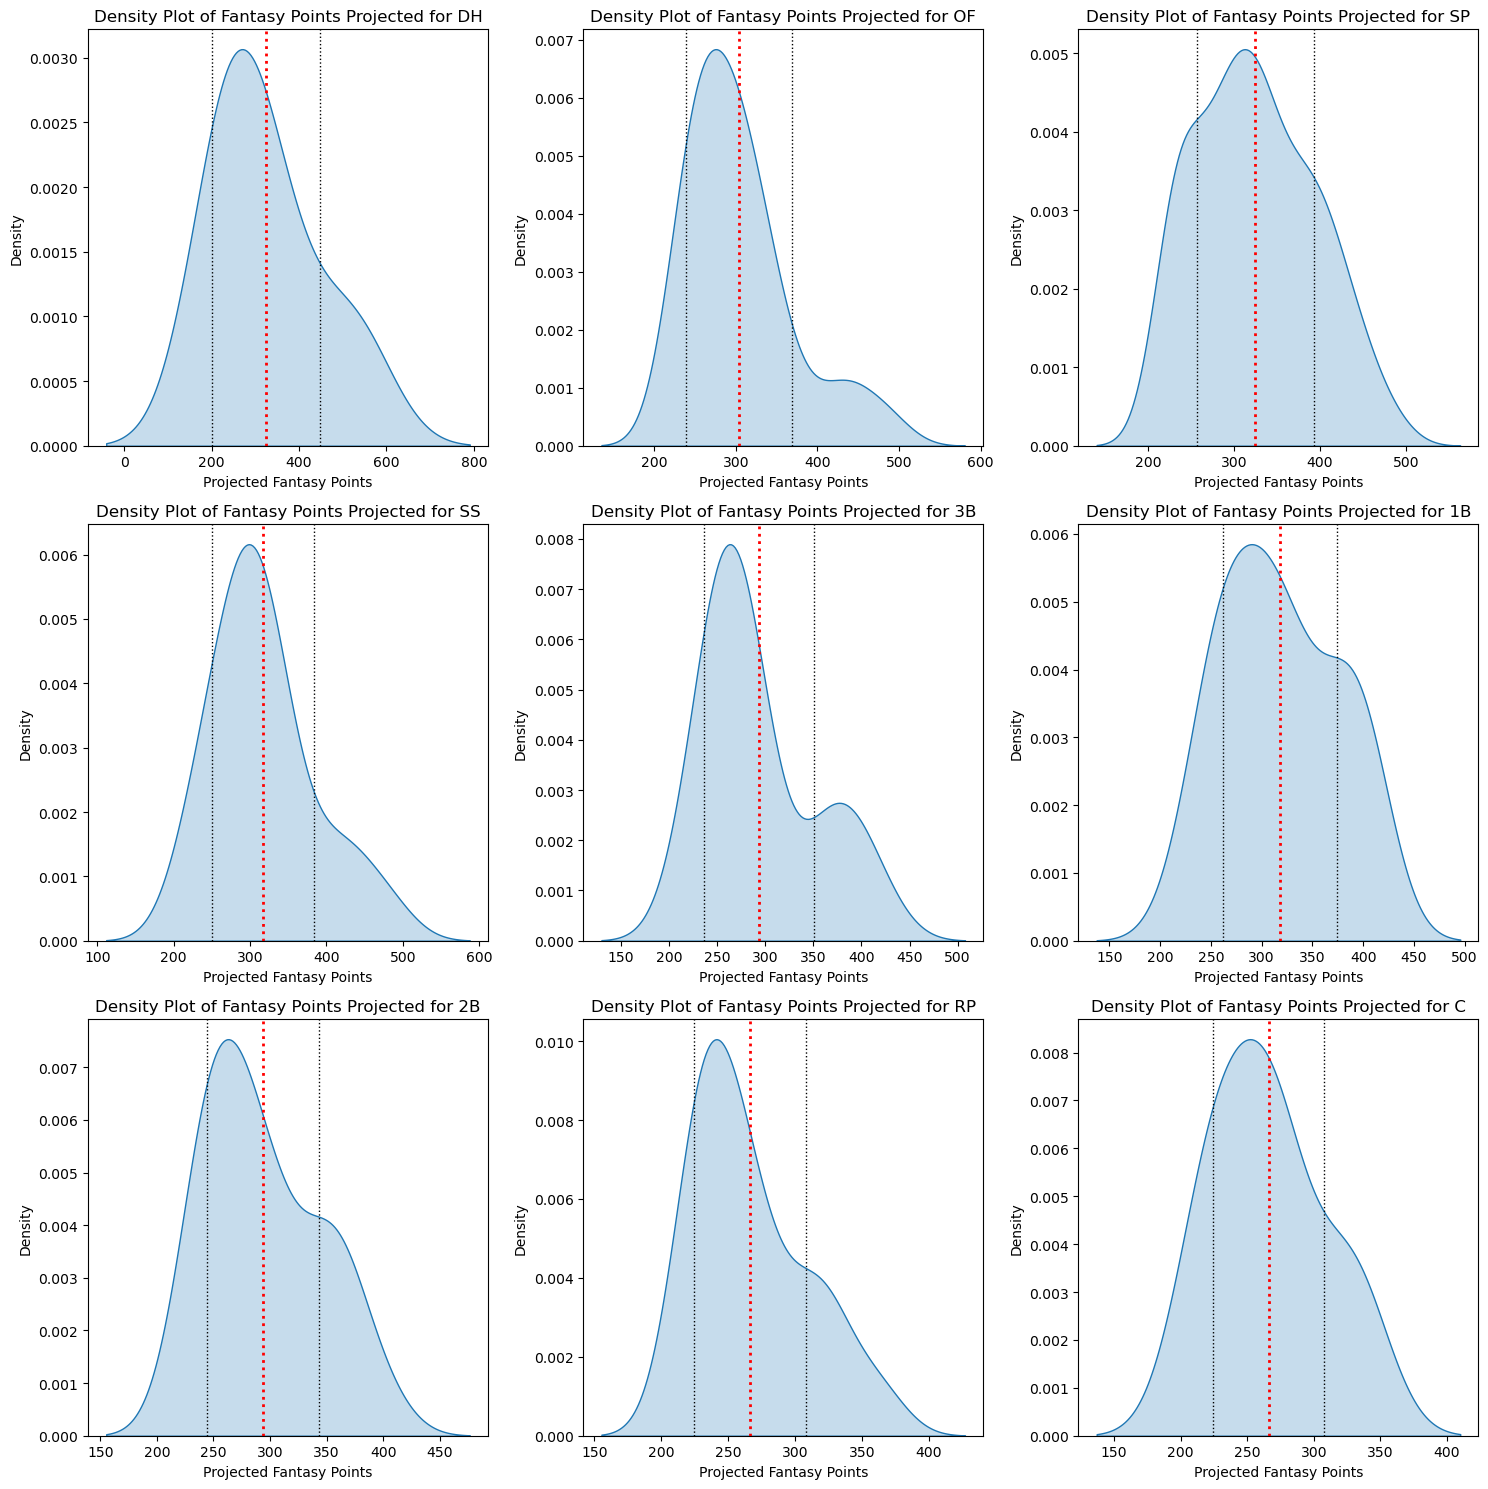

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Get unique positions
positions = all_preds_400_exploded['Pos'].unique()


num_positions = len(positions)
num_cols = 3
num_rows = (num_positions + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, pos in enumerate(positions):
    subset = all_preds_400_exploded[all_preds_400_exploded['Pos'] == pos]
    sns.kdeplot(subset['proj_fpoints'], shade=True, ax=axes[i])
    mean = pos_stats[pos_stats['Pos'] == pos]['mean'].values[0]
    std = pos_stats[pos_stats['Pos'] == pos]['std'].values[0]
    
    axes[i].axvline(mean, color='red', linestyle='dotted', linewidth=2)
    axes[i].axvline(mean + std, color='black', linestyle='dotted', linewidth=1)
    axes[i].axvline(mean - std, color='black', linestyle='dotted', linewidth=1)
    axes[i].set_title(f'Density Plot of Fantasy Points Projected for {pos}')
    axes[i].set_xlabel('Projected Fantasy Points')
    axes[i].set_ylabel('Density')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# plt.savefig("figures/position_density_plots.png")

In [7]:
## Calculating positional adjustment:

pos_stats['pos_adj'] = (((pos_stats['mean'] - pos_stats['mean'].mean()) / pos_stats['std']) * all_preds_400['proj_fpoints'].std()) * 0.5
pos_stats


,Pos,mean,std,pos_adj
0,1B,318.443163,56.075784,10.283158
1,2B,293.959894,49.418393,-4.702697
2,3B,293.207156,57.152359,-4.501539
3,C,265.968458,41.566484,-27.843611
4,DH,324.484343,122.915289,6.315435
5,OF,304.163919,64.816432,1.616666
6,RP,266.542716,41.880808,-27.181542
7,SP,324.950653,68.451769,11.565406
8,SS,317.215255,66.471237,8.064550


In [8]:
## Including roster contstraints:
num_c = 1.5
num_2b = 1.5
num_1b = 1.5
num_3b = 1.5
num_ss = 1.5
num_of = 0.9
num_rp = 1.5
num_sp = 0.5
## Making DH a higher value since it is restriced to UTIL
## This will lower the positional adjustment
num_dh = 0.5
# Find the maximum number of players for any position
num_max = max(num_c, num_2b, num_1b, num_3b, num_ss, num_of, num_rp, num_sp, num_dh)

# Create a dictionary for the number of players per position
num_dict = {
    'C': num_c,
    '2B': num_2b,
    '1B': num_1b,
    '3B': num_3b,
    'SS': num_ss,
    'OF': num_of,
    'RP': num_rp,
    'SP': num_sp,
    'DH': num_dh
}

# Apply the adjustment to pos_stats
pos_stats['pos_adj'] = pos_stats.apply(lambda row: row['pos_adj'] * num_max / num_dict[row['Pos']], axis=1)
pos_stats

,Pos,mean,std,pos_adj
0,1B,318.443163,56.075784,10.283158
1,2B,293.959894,49.418393,-4.702697
2,3B,293.207156,57.152359,-4.501539
3,C,265.968458,41.566484,-27.843611
4,DH,324.484343,122.915289,18.946305
5,OF,304.163919,64.816432,2.694444
6,RP,266.542716,41.880808,-27.181542
7,SP,324.950653,68.451769,34.696217
8,SS,317.215255,66.471237,8.064550


In [9]:
# Calculate the mean of all batting positions
batting_positions = pos_stats[~pos_stats['Pos'].isin(['RP', 'SP'])]
mean_batting = batting_positions['mean'].mean()

# Calculate the difference between the mean of SP and the mean of all batting positions
mean_sp = pos_stats[pos_stats['Pos'] == 'SP']['mean'].values[0]
difference = mean_sp - mean_batting

# Increase the pos_adj for SP by the calculated difference
pos_stats.loc[pos_stats['Pos'] == 'SP', 'pos_adj'] += difference

# Reducing RP adjustment by the difference - as RP should also take a hit compared to batter
pos_stats.loc[pos_stats['Pos'] == 'RP', 'pos_adj'] += (difference)

pos_stats

,Pos,mean,std,pos_adj
0,1B,318.443163,56.075784,10.283158
1,2B,293.959894,49.418393,-4.702697
2,3B,293.207156,57.152359,-4.501539
3,C,265.968458,41.566484,-27.843611
4,DH,324.484343,122.915289,18.946305
5,OF,304.163919,64.816432,2.694444
6,RP,266.542716,41.880808,-4.722630
7,SP,324.950653,68.451769,57.155129
8,SS,317.215255,66.471237,8.064550


In [10]:
pos_merged = all_preds_400_exploded.merge(pos_stats, on='Pos', how='left')
pos_merged.head(30)

,Rank,Name,Pos,proj_fpoints,mean,std,pos_adj
0,1.0,Shohei Ohtani,DH,523.326236,324.484343,122.915289,18.946305
1,2.0,Juan Soto,OF,493.869248,304.163919,64.816432,2.694444
2,3.0,Zack Wheeler,SP,485.404123,324.950653,68.451769,57.155129
3,4.0,Tarik Skubal,SP,484.581049,324.950653,68.451769,57.155129
4,5.0,Bobby Witt Jr.,SS,476.943711,317.215255,66.471237,8.064550
5,6.0,Aaron Judge,OF,473.160749,304.163919,64.816432,2.694444
6,7.0,Chris Sale,SP,454.918572,324.950653,68.451769,57.155129
7,8.0,Kyle Tucker,OF,454.088761,304.163919,64.816432,2.694444
8,9.0,Paul Skenes,SP,453.792118,324.950653,68.451769,57.155129
9,10.0,Logan Gilbert,SP,453.762465,324.950653,68.451769,57.155129


In [11]:
# Group by 'Name' and aggregate 'Pos' and 'pos_adj'
combined_pos_merged = pos_merged.groupby('Name').agg({
    'Pos': lambda x: '/'.join(sorted(x)),
    'pos_adj': 'min',
    'Rank': 'first',
    'proj_fpoints': 'first',
    'mean': 'first',
    'std': 'first'
}).reset_index()

combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(30)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
253,Shohei Ohtani,DH/SP,18.946305,1.0,523.326236,324.484343,122.915289
145,Juan Soto,OF,2.694444,2.0,493.869248,304.163919,64.816432
298,Zack Wheeler,SP,57.155129,3.0,485.404123,324.950653,68.451769
267,Tarik Skubal,SP,57.155129,4.0,484.581049,324.950653,68.451769
24,Bobby Witt Jr.,SS,8.064550,5.0,476.943711,317.215255,66.471237
3,Aaron Judge,OF,2.694444,6.0,473.160749,304.163919,64.816432
51,Chris Sale,SP,57.155129,7.0,454.918572,324.950653,68.451769
167,Kyle Tucker,OF,2.694444,8.0,454.088761,304.163919,64.816432
223,Paul Skenes,SP,57.155129,9.0,453.792118,324.950653,68.451769
171,Logan Gilbert,SP,57.155129,10.0,453.762465,324.950653,68.451769


In [12]:
# Define the positions for which we need to subtract 10 or 20 from pos_adj
multi_pos_10 = {'1B', '2B', '3B', 'SS', 'OF'}
multi_pos_20 = {'C'}

# Function to adjust pos_adj based on multiple positions
def adjust_pos_adj(row):
    positions = set(row['Pos'].split('/'))
    if len(positions) > 1:
        if positions & multi_pos_20:
            return row['pos_adj'] - 20
        elif positions & multi_pos_10:
            return row['pos_adj'] - 5
    return row['pos_adj']

# Apply the adjustment
combined_pos_merged['pos_adj'] = combined_pos_merged.apply(adjust_pos_adj, axis=1)
combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(40)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
253,Shohei Ohtani,DH/SP,18.946305,1.0,523.326236,324.484343,122.915289
145,Juan Soto,OF,2.694444,2.0,493.869248,304.163919,64.816432
298,Zack Wheeler,SP,57.155129,3.0,485.404123,324.950653,68.451769
267,Tarik Skubal,SP,57.155129,4.0,484.581049,324.950653,68.451769
24,Bobby Witt Jr.,SS,8.064550,5.0,476.943711,317.215255,66.471237
3,Aaron Judge,OF,2.694444,6.0,473.160749,304.163919,64.816432
51,Chris Sale,SP,57.155129,7.0,454.918572,324.950653,68.451769
167,Kyle Tucker,OF,2.694444,8.0,454.088761,304.163919,64.816432
223,Paul Skenes,SP,57.155129,9.0,453.792118,324.950653,68.451769
171,Logan Gilbert,SP,57.155129,10.0,453.762465,324.950653,68.451769


In [13]:
combined_pos_merged['Fantasy Points Adjusted'] = combined_pos_merged['proj_fpoints'] - combined_pos_merged['pos_adj']
full_rankings = combined_pos_merged[["Fantasy Points Adjusted", "Name", "Pos", 'proj_fpoints']]
full_rankings['Rank'] = full_rankings['Fantasy Points Adjusted'].rank(ascending=False)
full_rankings.set_index('Rank', inplace=True)
full_rankings=full_rankings.drop(columns = ["Fantasy Points Adjusted"])
full_rankings.sort_values(by = 'Rank', ascending = True).head(50)

,Name,Pos,proj_fpoints
Rank,,,
1.0,Shohei Ohtani,DH/SP,523.326236
2.0,Juan Soto,OF,493.869248
3.0,Aaron Judge,OF,473.160749
4.0,Bobby Witt Jr.,SS,476.943711
5.0,Kyle Tucker,OF,454.088761
6.0,Yordan Alvarez,OF,436.081950
7.0,Zack Wheeler,SP,485.404123
8.0,Tarik Skubal,SP,484.581049
9.0,Mookie Betts,OF/SS,423.058672


In [15]:
full_rankings.sort_values(by = 'Rank', ascending = True).to_csv("predictions/full_ranks.csv")